# Compare Gaussian fits across all flights

In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import pickle, glob, yaml

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
from beamcals.sites import site

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')


freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'

In [2]:
## Define anything I want to keep common
dotsize=1
freq_i = 900
# this may change per flight
# if I want to exclude known bad channels:
Epols = [0,2,8,10,14]
Npols = [1,3,9,11,15]

#otherwise, this is the mapping
#Epols = [0,2,4,6,8,10,12,14]
#Npols = [1,3,5,7,9,11,13,15]

# Amplitude checks

In [ ]:
#fli = np.arange(0,7)
#flx = [618,619,625,536,646,647,533]

flx = {
    '618' : '0',
    '619' : '1',
    '625' : '2',
    '536' : '3',
    '646' : '4',
    '647' : '5',
    '533' : '6'
}


In [ ]:
for i in range(0,len(varm[:,0])):
    print(varm[i,0],varm[i,1],varm[i,2],varm[i,3],varm[i,4],varm[i,5])

In [ ]:
flarr_indata = np.zeros([7,7])
flarr_andata = np.zeros([7,7])
flarr_interp = np.zeros([7,7])
flarr_anterp = np.zeros([7,7])

nv = len(varm[:,0])
for i in range(0,nv): 
    fl1 = str(int(varm[i,0]))
    fl2 = str(int(varm[i,1]))
    flarr_indata[int(flx[fl1]),int(flx[fl2])] = varm[i,2]
    flarr_andata[int(flx[fl1]),int(flx[fl2])] = varm[i,3]
    flarr_interp[int(flx[fl1]),int(flx[fl2])] = varm[i,4]
    flarr_anterp[int(flx[fl1]),int(flx[fl2])] = varm[i,5]
print(flarr_andata)

In [ ]:
print(flarr_anterp)

In [ ]:
print(flarr_andata - flarr_anterp)

In [ ]:
# 1/ and flip it - let's use annulus mask with data
flarrinv = np.zeros([7,7])

nv = len(varm[:,0])
for i in range(0,nv): 
    fl1 = str(int(varm[i,0]))
    fl2 = str(int(varm[i,1]))
    flarrinv[int(flx[fl2]),int(flx[fl1])] = 1./varm[i,3]
print(flarrinv)

print(flarr_andata-flarrinv) 
# overall bias that taking 1./ and flipping is smaller (ie, we're overall)

In [ ]:
##################################################
############# Spec an measurements ###############
##################################################

# There were some wierdnesses, check first spectra from the Oct flights

sdire = '/hirax/GBO_Oct_2021/spec_an_data/FSH4/gbo-1020/'
mess = glob.glob(sdire+'*'+'ns'+'*')
fig = plt.figure(figsize=(10,6))
for ms in mess:
    dat = np.loadtxt(ms,skiprows=100,delimiter=',',usecols=(0,1))

    plt.plot(dat[:,0]/1E6,dat[:,1],label=ms)
#plt.legend()
plt.show()

# Here I'm trying to match them to the flights

# 46dB attenuated flights
sdire = '/hirax/GBO_Oct_2021/spec_an_data/FSH4/gbo-1020/'
mess = ['ns-013.csv','ns-014.csv','ns-015.csv','ns-016.csv','ns-017.csv','ns-018.csv','ns-019.csv']
fig = plt.figure(figsize=(8,6))
for ms in mess:
    dat = np.loadtxt(sdire+ms,skiprows=100,delimiter=',',usecols=(0,1))

    plt.plot(dat[:,0]/1E6,dat[:,1],label=ms)
plt.legend()
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude [dBm]')
plt.title('46dB atten level: flights 618, 619, 620, 623')
plt.show()

sdire = '/hirax/GBO_Oct_2021/spec_an_data/FSH4/gbo-1020/'
mess = ['ns-019.csv','ns-020.csv']
fig = plt.figure(figsize=(8,6))
for ms in mess:
    dat = np.loadtxt(sdire+ms,skiprows=100,delimiter=',',usecols=(0,1))

    plt.plot(dat[:,0]/1E6,dat[:,1],label=ms)
plt.legend()
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude [dBm]')
plt.title('36dB atten level: flight 625  -- may have changed attenuation after')
plt.show()

sdire = '/hirax/GBO_Oct_2021/spec_an_data/FSH4/gbo-1020/'
mess = ['ns-027.csv','ns-028.csv','ns-029.csv']
fig = plt.figure(figsize=(8,6))
for ms in mess:
    dat = np.loadtxt(sdire+ms,skiprows=100,delimiter=',',usecols=(0,1))

    plt.plot(dat[:,0]/1E6,dat[:,1],label=ms)
plt.legend()
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude [dBm]')
plt.title('30dB atten level: flights 646,647,648,649')
plt.show()



In [ ]:
## North-polarized flights:

flies = ['618','619','623','625','536','646','647','533']
attn = ['-NS-46', '-EW-46','-NS-46','-NS-46','-NS-43','-NS-40','-EW-40','-EW-36']
pols = Npols
markers = ['s','v','^','>','P','x','+','o']

for p in range(0,len(pols)):

    fig = plt.figure(figsize=(8,6))

    for f in range(0,len(flies)):
        fly = flies[f]
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        plt.plot(freqs,fits['G_popt'][pols[p],:,0],marker='.',markersize=1,linestyle='None',label=fly+attn[f])
    plt.title('INPUT: '+str(pols[p]))
    plt.ylim(0,4E-7)
    plt.xlabel('frequency [MHz]')
    plt.ylabel('Amplitude [arb]')
    plt.legend(markerscale=10)
    plt.show()


In [ ]:
## East-polarized flights:

flies = ['620','648','649','534','535']
attn = ['-NS-46','-NS-40','-EW-40','-NS-36','-EW-36']
pols = Epols
markers = ['s','v','^','>','P','x','+','o']

for p in range(0,len(pols)):

    fig = plt.figure(figsize=(8,6))

    for f in range(0,len(flies)):
        fly = flies[f]
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        try:
            plt.plot(freqs,fits['G_popt'][pols[p],:,0],marker='.',markersize=1,linestyle='None',label=fly+attn[f])
        except:''
    plt.title('Input: '+str(pols[p]))
    plt.ylim(0,4E-7)
    plt.xlabel('frequency [MHz]')
    plt.ylabel('Amplitude [arb]')
    plt.legend(markerscale=10)
    plt.show()

In [ ]:
## Compare to expected ratios --- N pol flights:

flies = ['619','623','625','646','647']
exprat = [1.0, 1.0, 1.0, 4.5, 4.5] #using ratio from spec an measurement
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','green','blue','purple','pink']

fly = '618'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

# check the ratio for the later flights:
specans = ['ns-016.csv','ns-018.csv','ns-019.csv','ns-028.csv','ns-029.csv']
dat618 = np.loadtxt(sdire+'ns-015.csv',skiprows=100,delimiter=',',usecols=(0,1))
    


fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    print(ffile)
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        plt.plot(freqs,fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
    dat = np.loadtxt(sdire+specans[f],skiprows=100,delimiter=',',usecols=(0,1))
    plt.plot(dat[:,0]/1E6,10**(dat[:,1]/10.) / 10**(dat618[:,1]/10.),color='black',linewidth=5)
plt.title('Amplitudes relative to flight 618')
plt.legend(ncol=5)
plt.ylim(0,10)
plt.show()

In [ ]:
## Compare to expected ratios --- N pol flights:

flies = ['619','623','625','536','646','647','533']
exprat = [1.0, 1.0, 1.0, 2.0, 4.5, 4.5, 10.0] #using ratio from spec an measurement
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','green','blue','purple','pink','grey']

fly = '618'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)


fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            plt.plot(freqs,fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
        except:''
    plt.text(420+ (30*f), 9, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618')
#plt.legend()
plt.ylim(0,10)
plt.show()


fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
    plt.text(420+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618 / expected ratio')
#plt.legend()
plt.ylim(0,1.2)
plt.show()

In [ ]:
## Compare to expected ratios ---- E pol flights:

flies = flies = ['535','534','648','649']
exprat = [10.0, 10.0, 4.5, 4.5]
pols = Epols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','green','blue','purple']

fly = '620'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            plt.plot(freqs,fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
        except:''
    plt.text(550+ (30*f), 9, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618')
plt.ylim(0,10)
plt.show()

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
        except:''
    plt.text(420+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618 / expected ratio')
plt.ylim(0,1.2)
plt.show()



In [ ]:
# Try to combine...

## Npols
flies = ['619','623','625','536','646','647','533']
exprat = [1.0, 1.0, 1.0, 2.0, 4.5, 4.5, 10.0] #using ratio from spec an measurement
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','green','grey','purple','pink','blue']

fly = '618'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
    plt.text(390+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618 / expected ratio')

## Epols
flies = ['648','649','535','534']
exprat = [4.5, 4.5, 10.0, 10.0]
pols = Epols
markers = ['s','v','^','>','P','x','+','o']
colors=['violet','magenta','royalblue','dodgerblue']

fly = '620'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
        except:''
    plt.text(620+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to 618 or 620 / expected ratio')
#plt.legend()
plt.ylim(0,1.2)
plt.show()

In [ ]:
## Since the 500 flights are outliers, try to use one of those as a calibrator.
# Statistics are low, but helpful to see

## Npols
flies = ['533']
exprat = [5.0] #using ratio from spec an measurement
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['blue']

fly = '536'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0]),marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
    plt.text(390+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618 / expected ratio')

## Epols
flies = ['535']
exprat = [1.0]
pols = Epols
markers = ['s','v','^','>','P','x','+','o']
colors=['royalblue']

fly = '534'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0]),marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
        except:''
    plt.text(620+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to 536 or 534 / expected ratio')
#plt.legend()
plt.ylim(0,5.0)
plt.show()


##### Compare with expected ratios #####

## Npols
flies = ['533']
exprat = [5.0] #using ratio from spec an measurement
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['blue']

fly = '536'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
    plt.text(390+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618 / expected ratio')

## Epols
flies = ['535']
exprat = [1.0]
pols = Epols
markers = ['s','v','^','>','P','x','+','o']
colors=['royalblue']

fly = '534'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
        except:''
    plt.text(620+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to 536 or 534 / expected ratio')
#plt.legend()
plt.ylim(0,1.2)
plt.show()

In [ ]:
### ATTEMPT TO CORRECT FOR THE AMPLITUDES
# First use the variance values, this is true for only dish 0, one frequency
rattN = [1.0, 1.0, 1.0, 0.86, 0.92, 1.0, 1.78]

## Npols
flies = ['619','623','625','536','646','647','533']

exprat = [1.0, 1.0, 1.0, 2.0, 4.5, 4.5, 10.0] #using ratio from spec an measurement
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','green','grey','purple','pink','blue']

fly = '618'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,1):#len(pols)):
        plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
    plt.text(390+ (30*f), 0.6, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618 / expected ratio')
plt.ylim(0.5,1.5)
plt.xlim(400,600)

## Epols
flies = ['648','649','535','534']
exprat = [4.5, 4.5, 10.0, 10.0]
pols = Epols
markers = ['s','v','^','>','P','x','+','o']
colors=['violet','magenta','royalblue','dodgerblue']

fly = '620'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

#for f in range(0,len(flies)):
#    fly = flies[f]
#    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
#    fits = np.load(ffile)
#    for p in range(0,len(pols)):
#        try:
#            plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
#        except:''
#    plt.text(620+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
#plt.title('Amplitudes relative to 618 or 620 / expected ratio')
##plt.legend()
#plt.ylim(0,1.2)
#plt.show()

In [ ]:
### ATTEMPT TO CORRECT FOR THE AMPLITUDES
# First use the variance values, this is true for only dish 0, one frequency
rattN = [1.0, 1.0, 1.0, 0.86, 0.92, 1.0, 1.78]

## Npols
flies = ['619','623','625','536','646','647','533']

exprat = [1.0, 1.0, 1.0, 2.0, 4.5, 4.5, 10.0] #using ratio from spec an measurement
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','green','grey','purple','pink','blue']

fly = '618'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,1):#len(pols)):
        plt.plot(freqs,(fits['G_popt'][pols[p],:,0]*rattN[f]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
    plt.text(390+ (30*f), 0.6, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618 / expected ratio')
plt.ylim(0.5,1.5)
plt.xlim(400,600)

## Epols
flies = ['648','649','535','534']
exprat = [4.5, 4.5, 10.0, 10.0]
pols = Epols
markers = ['s','v','^','>','P','x','+','o']
colors=['violet','magenta','royalblue','dodgerblue']

fly = '620'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

#for f in range(0,len(flies)):
#    fly = flies[f]
#    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
#    fits = np.load(ffile)
#    for p in range(0,len(pols)):
#        try:
#            plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
#        except:''
#    plt.text(620+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
#plt.title('Amplitudes relative to 618 or 620 / expected ratio')
##plt.legend()
#plt.ylim(0,1.2)
#plt.show()

# Timing offsets

In [ ]:
ymlfiles = os.listdir(ymldir)
flytags = []
toffs = []
for ymlfile in ymlfiles:
    with open(ymldir+ymlfile, 'r') as fff:
        documents = yaml.safe_load(fff)
        print(documents["file_info"]["FLYTAG"],documents["timing_params"]["t_delta_dji"])
        flytags.append(documents["file_info"]["FLYTAG"])
        toffs.append(documents["timing_params"]["t_delta_dji"])
labels = flytags
x = np.arange(0,len(toffs))
# Plot both separately

plt.plot(toffs,'k.')
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Timing offset (s)')
plt.show()

# FWHMs

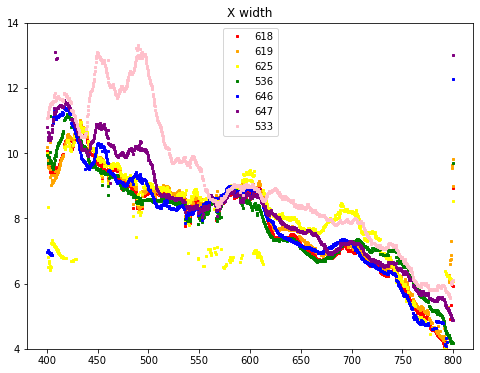

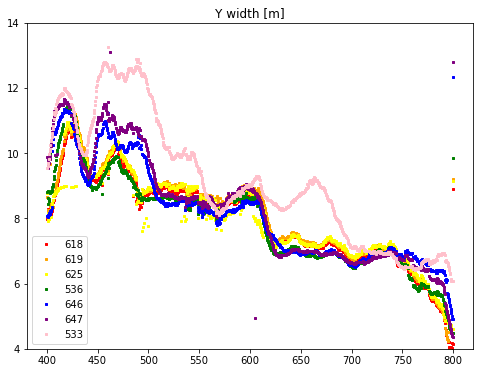

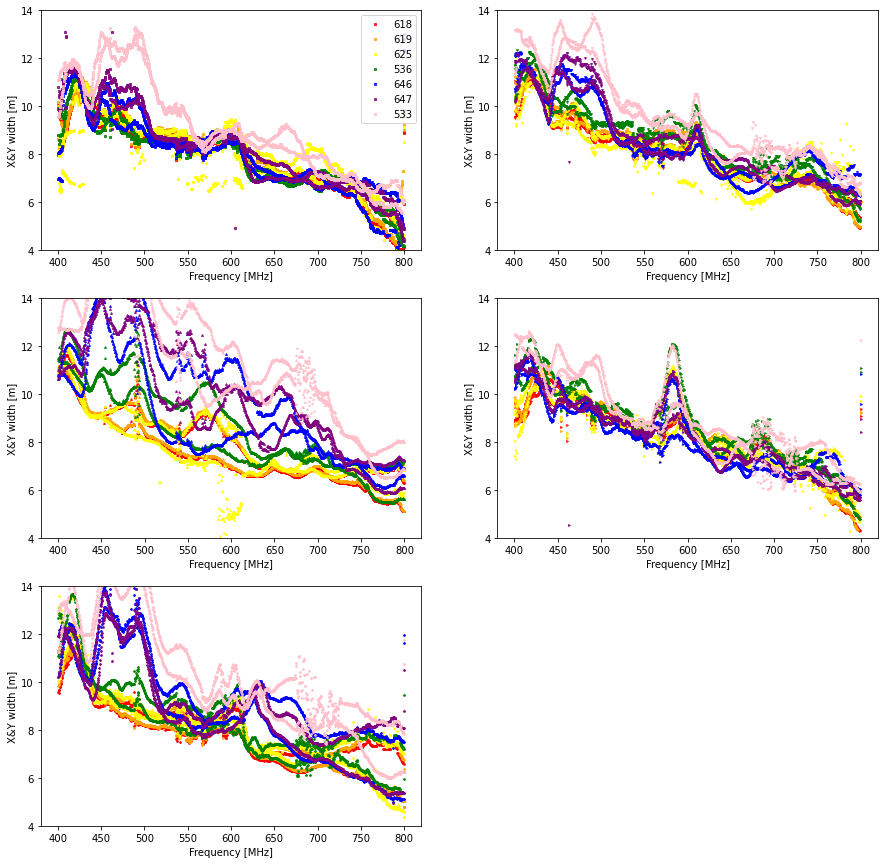

In [3]:
## N pol flights

flies = ['618','619','625','536','646', '647','533']
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','yellow','green','blue','purple','pink']
p = 0

# X width
fig = plt.figure(figsize=(8,6))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    #for p in range(0,len(pols)):
    plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
plt.title('X width')
plt.legend()
plt.ylim(4,14)
plt.show()

# Y width
fig = plt.figure(figsize=(8,6))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    #for p in range(0,len(pols)):
    plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
plt.title('Y width [m]')
plt.legend()
plt.ylim(4,14)
plt.show()

a = 0.8
plt.figure(1,figsize=(15,15))
plt.subplot(321)
p = 0
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a,label=fly)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.legend()
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(322)
p = 1
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(323)
p = 2
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(324)
p = 3
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(325)
p = 4
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.show()



In [ ]:
## E pol flights

flies = ['620','648','649','534','535']
pols = Epols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','yellow','green','blue','purple','pink']
p = 0

# X width
fig = plt.figure(figsize=(8,6))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    #for p in range(0,len(pols)):
    plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
plt.title('X width')
plt.legend()
plt.ylim(4,14)
plt.show()

# Y width
fig = plt.figure(figsize=(8,6))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    #for p in range(0,len(pols)):
    plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
plt.title('Y width [m]')
plt.legend()
plt.ylim(4,14)
plt.show()

a = 0.8
plt.figure(1,figsize=(15,15))
plt.subplot(321)
p = 0
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a,label=fly)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.legend()
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(322)
p = 1
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(323)
p = 2
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(324)
p = 3
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(325)
p = 4
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.show()



# Offsets

In [ ]:
## N pol flights:

flies = ['618','619','623','625','646','647']
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','green','blue','purple','pink']

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        plt.plot(freqs,fits['G_popt'][pols[p],:,5],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
plt.title('Offsets')
plt.legend()
plt.ylim(0,2E-9)
plt.show()

In [ ]:
# E pol flights
flies = ['620','648','649','534','535']
pols = Epols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','green','blue','purple','pink']

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            plt.plot(freqs,fits['G_popt'][pols[p],:,5],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
        except:''
plt.title('Offsets')
plt.legend()
plt.ylim(0,2E-9)
for i in range(0,5):
    plt.axvline(440 + 63*i,color='black',lw=3)

plt.show()

In [4]:
print(3E8/63E6)

fD = 0.398 # from pranav
6*(fD)*2

4.761904761904762


4.776

0 618 618
1 533 533
2 619 619
3 647 647
4 536 536
5 618 618
6 623 623
7 625 625


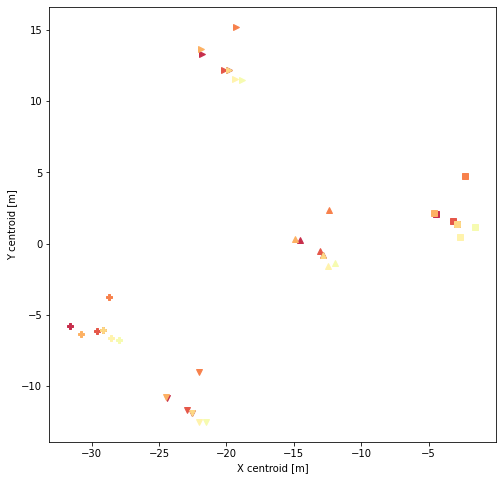

In [12]:
markers = ['s','v','^','>','P','x','+','o']
cmap = cm.get_cmap('Spectral')
## North-polarized flights:

flies = ['618','533','619','647','536','618','623','625']
pols = Npols

fig = plt.figure(figsize=(8,8))
for f in range(0,len(flies)):
    fly = flies[f]
    print(f, flies[f],fly)
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        plt.plot(fits['G_popt'][pols[p],freq_i,1],fits['G_popt'][pols[p],freq_i,3],
                 marker=markers[p],color=cmap(f/13),linestyle='None',label=fly)
plt.xlabel('X centroid [m]')
plt.ylabel('Y centroid [m]')
plt.show()

# Centroid locations

[1, 3, 9, 11, 15]


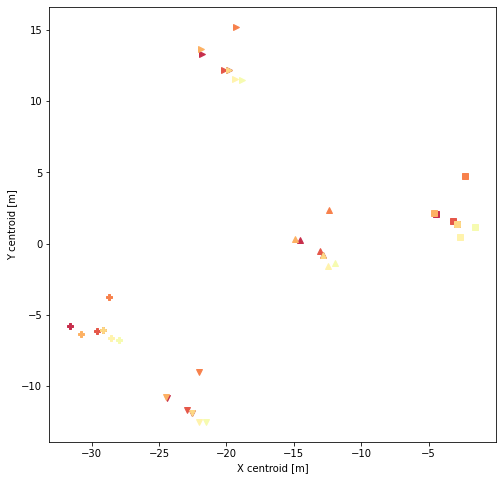

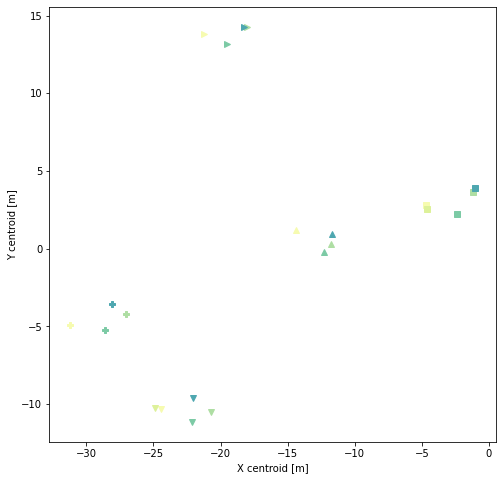

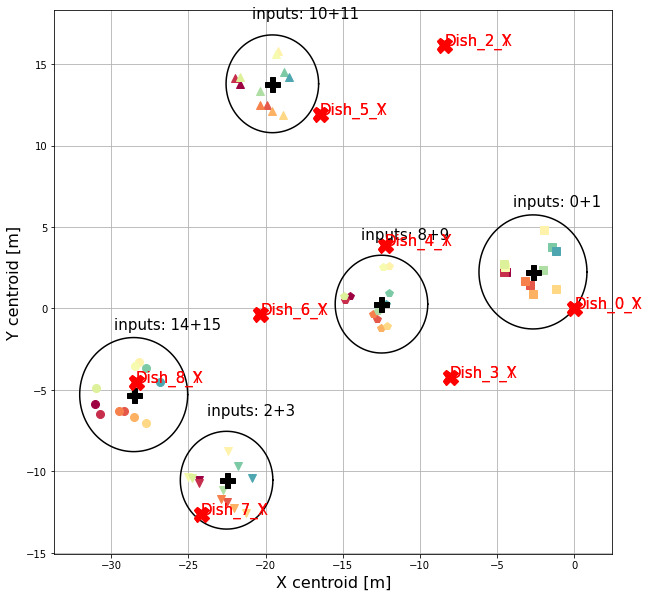

In [8]:
markers = ['s','v','^','>','P','x','+','o']
cmap = cm.get_cmap('Spectral')
## North-polarized flights:

flies = ['618','533','619','647','536','618','623','625']
pols = Npols

fig = plt.figure(figsize=(8,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        plt.plot(fits['G_popt'][pols[p],freq_i,1],fits['G_popt'][pols[p],freq_i,3],
                 marker=markers[p],color=cmap(f/13),linestyle='None',label=fly)
plt.xlabel('X centroid [m]')
plt.ylabel('Y centroid [m]')
plt.show()


## East-polarized flights:

flies = ['535','534','649','620','648']
pols = Epols


fig = plt.figure(figsize=(8,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            plt.plot(fits['G_popt'][pols[p],freq_i,1],fits['G_popt'][pols[p],freq_i,3],color=cmap((f+7)/13),marker=markers[p],linestyle='None',label=fly)
        except:''
plt.xlabel('X centroid [m]')
plt.ylabel('Y centroid [m]')
plt.show()

## ## Combine the two together, take a median over all frequencies, make plot above look nice ## ##

cms = np.zeros([13,len(pols),2]) # flight, pol (0-7), X,Y

flies = ['533','536','618','619','623','625','646','647']
pols = Npols
F = len(flies)

for f in range(0,len(flies)):
    ffile = glob.glob(fitdir+'*'+flies[f]+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        #cms[f,p,0] = np.nanmedian(fits['G_popt'][pols[p],:,1])
        #cms[f,p,1] = np.nanmedian(fits['G_popt'][pols[p],:,3])
        cms[f,p,0] = np.nanmedian(fits['G_popt'][pols[p],650:-1,1]) # less than 550 MHz
        cms[f,p,1] = np.nanmedian(fits['G_popt'][pols[p],650:-1,3]) # less than 550 MHz
        
flies = ['534','535','620','648','649']
pols = Epols

for f in range(0,len(flies)):
    ffile = glob.glob(fitdir+'*'+flies[f]+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            #cms[f+F-1,p,0] = np.nanmedian(fits['G_popt'][pols[p],:,1])
            #cms[f+F-1,p,1] = np.nanmedian(fits['G_popt'][pols[p],:,3])
            cms[f+F-1,p,0] = np.nanmedian(fits['G_popt'][pols[p],650:-1,1]) # less than 550 MHz
            cms[f+F-1,p,1] = np.nanmedian(fits['G_popt'][pols[p],650:-1,3]) # less than 550 MHz
        except:''

# marker by pol input (dish), color by flight
markers = ['s','v','p','^','o']
F = len(cms[:,0,0])

fig = plt.figure(figsize=(10,10))


Rs = [3.5,3,3,3,3.5]

for f in range(0,F):
    for p in range(0,len(pols)):
        plt.plot(cms[f,p,0],cms[f,p,1],marker=markers[p],color=cmap(f/13.),linestyle='None',markersize=8,label=fly)
for p in range(0,len(cms[0,:,0])):
    plt.plot(np.nanmedian(cms[:,p,0]),np.nanmedian(cms[:,p,1]),color='black',marker='P',markersize=15)
    
    plt.text(np.median(cms[:,p,0])-1.3,np.median(cms[:,p,1])+4,'inputs: '+str(Epols[p])+'+'+str(Npols[p]),fontsize=15)

    R = Rs[p]
    theta=np.arange(0,2*np.pi,0.001)
    circx,circy = [R*np.cos(theta),R*np.sin(theta)]
    plt.plot(np.median(cms[:,p,0]) + circx, np.median(cms[:,p,1])+circy,color='black')

for d in range(0,len(gbosite.coords[:,0])):
    plt.plot(gbosite.coords[d,0],gbosite.coords[d,1],color='red',marker='X',markersize=15)
    plt.text(gbosite.coords[d,0],gbosite.coords[d,1], gbosite.keystrings[d], color='red',fontsize=15)

plt.xlabel('X centroid [m]',fontsize=16)
plt.ylabel('Y centroid [m]',fontsize=16)
plt.grid()
plt.show()

/home/ln267/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


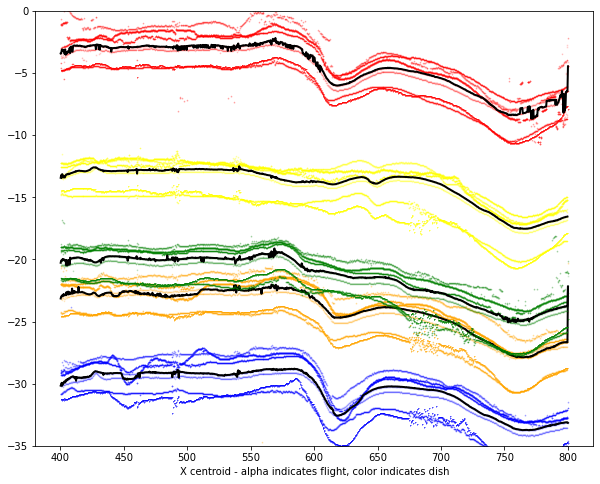

/home/ln267/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


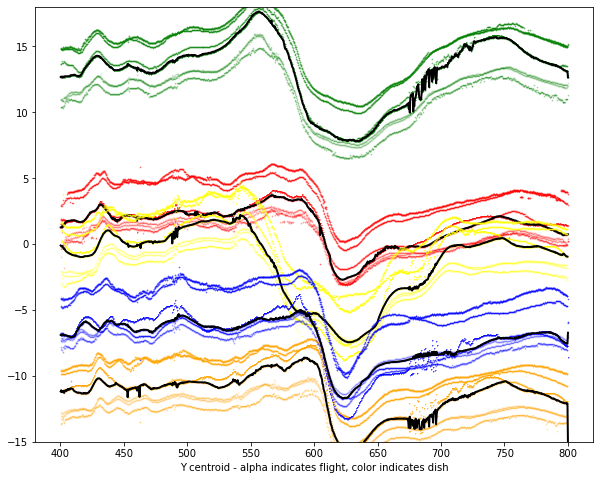

In [6]:
# N pols
flies = ['618','619','625','536','646', '647','533'] # ordered by brightness
#flies = ['533','536','618','619','625','646','647'] # ordered by time
pols = Npols


allfits = np.zeros([len(pols),1024,2,7]) # dish, freq, x/y, flight

#fig = plt.figure(figsize=(15,10))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        allfits[p,:,0,f] = fits['G_popt'][pols[p],:,1]
        allfits[p,:,1,f] = fits['G_popt'][pols[p],:,3]

markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','yellow','green','blue','purple','pink']
alphas=np.arange(0.1,0.9,0.1)


fig = plt.figure(figsize=(10,8))
for p in range(0,len(pols)):
    for f in range(0,len(flies)):
        plt.plot(freqs,allfits[p,:,0,f],
                 marker=markers[f],markersize=1,color=colors[p],linestyle='None',alpha=alphas[f])
    plt.plot(freqs,np.nanmedian(allfits[p,:,0,:],axis=1),color='black',lw=2)
plt.xlabel('Frequency [MHz]')
plt.xlabel('X centroid - alpha indicates flight, color indicates dish')
plt.ylim(-35,0)
#plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
for p in range(0,len(pols)):
    for f in range(0,len(flies)):
        plt.plot(freqs,allfits[p,:,1,f],
                 marker=markers[f],markersize=1,color=colors[p],linestyle='None',alpha=alphas[f])
    plt.plot(freqs,np.nanmedian(allfits[p,:,1,:],axis=1),color='black',lw=2)
plt.xlabel('Frequency [MHz]')
plt.xlabel('Y centroid - alpha indicates flight, color indicates dish')
plt.ylim(-15,18)
#plt.legend()
plt.show()

In [13]:
# N pols
flies = ['618','619','625','536','646', '647','533'] # ordered by brightness
#flies = ['533','536','618','619','625','646','647'] # ordered by time
pols = Npols


allfits = np.zeros([len(pols),1024,2,7]) # dish, freq, x/y, flight

#fig = plt.figure(figsize=(15,10))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        allfits[p,:,0,f] = fits['G_popt'][pols[p],:,1]
        allfits[p,:,1,f] = fits['G_popt'][pols[p],:,3]

markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','yellow','green','blue','purple','pink']
alphas=np.arange(0.1,0.9,0.1)





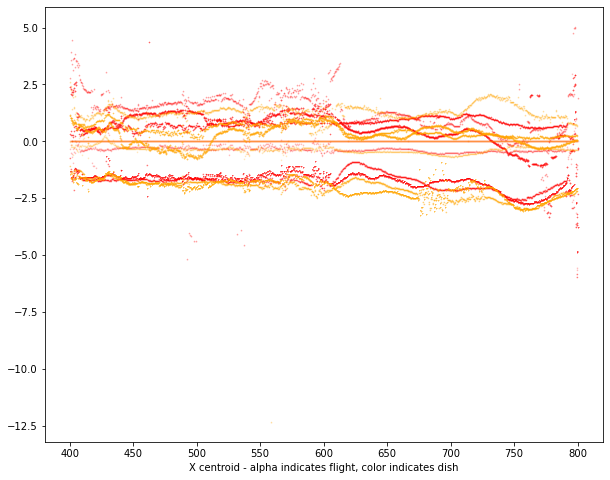

In [26]:
fig = plt.figure(figsize=(10,8))
for p in range(0,2):#len(pols)):
    for f in range(0,len(flies)):
        plt.plot(freqs,allfits[p,:,0,f]-allfits[p,:,0,0],
                 marker=markers[f],markersize=1,color=colors[p],linestyle='None',alpha=alphas[f])
plt.xlabel('Frequency [MHz]')
plt.xlabel('X centroid - alpha indicates flight, color indicates dish')
#plt.ylim(-10,0)
#plt.legend()
plt.show()


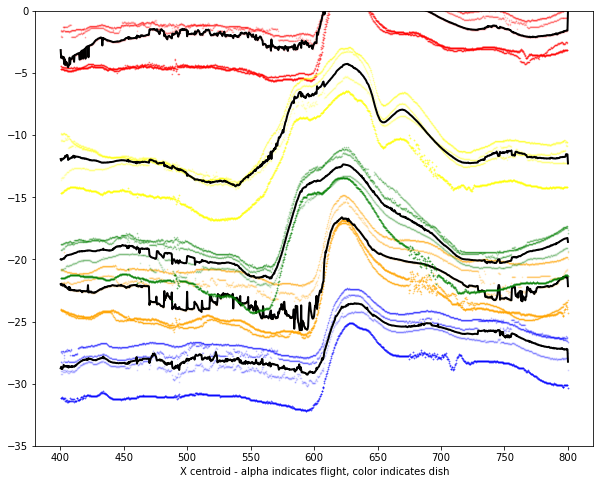

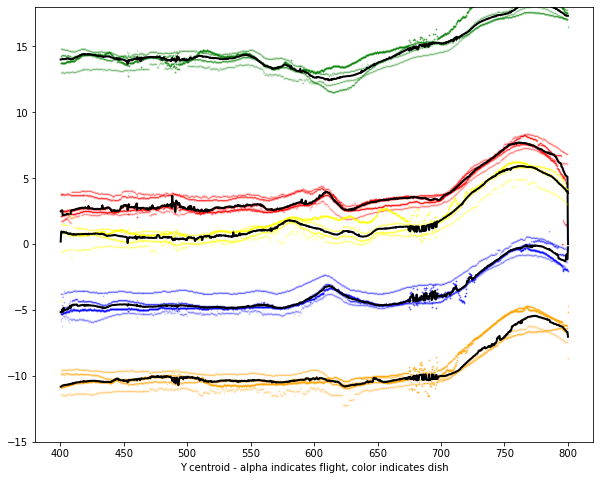

In [7]:
# E pols
flies = ['620','648','649','534','535'] # ordered by brightness
#flies = ['534','535','620','648','649'] # ordered by time
pols = Epols


#allfits = np.zeros([len(pols),1024,2,7]) # dish, freq, x/y, flight
allfits = np.empty((len(pols),1024,2,7))
allfits[:] = np.nan

#fig = plt.figure(figsize=(15,10))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            allfits[p,:,0,f] = fits['G_popt'][pols[p],:,1]
            allfits[p,:,1,f] = fits['G_popt'][pols[p],:,3]
        except:''

markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','yellow','green','blue','purple','pink']
alphas=np.arange(0.1,0.9,0.1)


fig = plt.figure(figsize=(10,8))
for p in range(0,len(pols)):
    for f in range(0,len(flies)):
        try:
            plt.plot(freqs,allfits[p,:,0,f],
                 marker=markers[f],markersize=1,color=colors[p],linestyle='None',alpha=alphas[f])
        except:''
    plt.plot(freqs,np.nanmedian(allfits[p,:,0,:],axis=1),color='black',lw=2)
plt.xlabel('Frequency [MHz]')
plt.xlabel('X centroid - alpha indicates flight, color indicates dish')
plt.ylim(-35,0)
#plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
for p in range(0,len(pols)):
    for f in range(0,len(flies)):
        try:
            plt.plot(freqs,allfits[p,:,1,f],
                 marker=markers[f],markersize=1,color=colors[p],linestyle='None',alpha=alphas[f])
        except:''
    plt.plot(freqs,np.nanmedian(allfits[p,:,1,:],axis=1),color='black',lw=2)
plt.xlabel('Frequency [MHz]')
plt.xlabel('Y centroid - alpha indicates flight, color indicates dish')
plt.ylim(-15,18)
#plt.legend()
plt.show()